# Análise e predição de recuperação e óbitos da Covid-19 em Minas Gerais

## Orientação
Este notebook foi criado no ambiente *Google Colab*, portanto para garantir o correto funcionamento recomenda-se que seja executado neste ambiente.

## Introdução
Trabalho de conclusão de curso de pós graduação em Ciência de dados e Big Data na PUC Minas - Virtual.

## Objetivo
Analisar os dados de óbitos e recuperações nas cidades e regiões de Minas Gerais e gerar modelos de machine learning (ML) para prever se determinado paciente infectado evoluirá para óbito ou recuperação.

## Preparação do ambiente
Importações de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

np.random.seed(9483) # semente padrão para estado aleatório
sns.set_theme() # tema padrão do seaborn
plt.rc("figure", figsize=(12,8)) # tamanho padrão de plotagem
color_palette = 'Reds_r' # paleta de cores padrão para os gráficos
fig_size = {'w':8,'h':5} # tamanho padrão para uso nos gráficos

## Obtenção dos dados

### Secretaria de Estado de Saúde de Minas Gerais - SES

Serão obtidos dados de recuperados, em acompanhamento e óbitos causados pela Covid-19 nos municípios de Minas Gerais.

Os dados são disponibilizados publicamente pela Secretaria de Estado de Saúde de Minas Gerais - SES, em formato *xlsx*, disponível em [https://coronavirus.saude.mg.gov.br/images/microdados/xlsx_sistemas.xlsx](https://coronavirus.saude.mg.gov.br/images/microdados/xlsx_sistemas.xlsx).

O arquivo é uma pasta de trabalho com apenas uma planilha, contendo informações específicas sobre os infectados da Covid-19 nos municípios.

Para este trabalho serão considerados os dados atualizados em 23/04/2021. O arquivo está disponível em ['https://github.com/fernando-resende/data-science/blob/main/covid-19/classification/datasets/xlsx_sistemas.xlsx?raw=true']('https://github.com/fernando-resende/data-science/blob/main/covid-19/classification/datasets/xlsx_sistemas.xlsx?raw=true').

Caso prefira avaliar os dados atuais, passe *True* como valor do parâmetro *download_from_source* na função *get_covid_dataframe*.

**Atenção:** arquivo grande, leva em média mais de 30 segundos para ser carregado.

In [2]:
# Se download_from_source = True, baixará os arquivos da fonte original
def get_covid_dataframe(download_from_source = False):
  if not download_from_source:
    covid_file_path = 'https://github.com/fernando-resende/data-science/blob/main/covid-19/classification/datasets/xlsx_sistemas.xlsx?raw=true'
  else:
    covid_file_path = 'https://coronavirus.saude.mg.gov.br/images/microdados/xlsx_sistemas.xlsx'
  return pd.read_excel(covid_file_path)

In [3]:
covid_demographic_mg = get_covid_dataframe()

Exibindo amostras aleatórias dos datasets

In [4]:
covid_demographic_mg.sample(5)

,ID,URS,MICRO,MACRO,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,DATA_EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
363567,363568,PASSOS,PASSOS,SUL,25/01/2021,CASO CONFIRMADO,MASCULINO,24.0,20 A 29 ANOS,NOVA RESENDE,314510.0,RECUPERADO,NaN,NAO,NAO,BRANCA,NAO INFORMADO,23/04/2021,ESUS
49559,49560,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO,26/08/2020,CASO CONFIRMADO,MASCULINO,55.0,50 A 59 ANOS,BELO HORIZONTE,310620.0,RECUPERADO,NaN,SIM,NAO,NAO INFORMADO,SIM,23/04/2021,SIVEP
451542,451543,VARGINHA,TRES PONTAS,SUL,22/03/2021,CASO CONFIRMADO,MASCULINO,58.0,50 A 59 ANOS,TRES PONTAS,316940.0,EM ACOMPANHAMENTO,NaN,NAO,NAO,PARDA,NAO INFORMADO,23/04/2021,ESUS
54996,54997,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO,27/11/2020,CASO CONFIRMADO,FEMININO,47.0,40 A 49 ANOS,BELO HORIZONTE,310620.0,RECUPERADO,NaN,SIM,NAO,PARDA,NAO,23/04/2021,SIVEP
167850,167851,DIVINOPOLIS,PARA DE MINAS,OESTE,07/11/2020,CASO CONFIRMADO,FEMININO,82.0,80 A 89 ANOS,PARA DE MINAS,314710.0,RECUPERADO,NaN,NAO,NAO,PARDA,NAO INFORMADO,23/04/2021,ESUS


### Web Scraping

Um dos requisitos do trabalho é utilizar técnica de web scraping para obter dados e enriquecer o(s) dataset(s).

Será utilizada uma fonte de dados com informações sobre a população estimada, salário médio e Índice de Desenvolvimento Humano Municipal (IDHM) nas cidades do estado de Minas Gerais.

Os dados serão obtidos do site do Instituto Brasileiro de Geografia e Estatística - IBGE, disponíveis no seguinte endereço [https://cidades.ibge.gov.br/brasil/sintese/mg?indicadores=29171,30255,29765](https://cidades.ibge.gov.br/brasil/sintese/mg?indicadores=29171,30255,29765).

A fonte de dados em questão é apresentada em forma de tabela, porém os dados são carregados dinamicamente. Dessa forma, o uso da biblioteca *requests* para obter a página web diretamente da fonte não atende, pois não consegue tratar carregamentos dinâmicos, resultando em uma tabela vazia quando utilizada.

Dessa forma, optou-se por gerar um arquivo HTML estático e disponibilizá-lo no GitHub, para então fazer uso das bibliotecas *requests* e *BeautifullSoup*. Arquivo disponível em [https://github.com/fernando-resende/data-science/blob/main/covid-19/classification/datasets/IBGE_Municipios_MG.html](https://github.com/fernando-resende/data-science/blob/main/covid-19/classification/datasets/IBGE_Municipios_MG.html).

Ainda há a opção de obter os dados diretamente da fonte pelo uso da biblioteca *Selenium*, que suporta páginas com conteúdo dinâmico, caso queira passe *True* como valor do parâmetro *download_from_source* na função *web_scraping_mg_cities*.

Caso opte pela obtenção dos dados da fonte original, serão feitas instalações, importações e configurações necessárias para execução no ambiente Google Colab. 

**Atenção:** a inicialização da sessão pelo *web driver* do *Selenium*, geração dinâmica dos dados, coleta e conversão em dataframe leva, em média, mais de 45 segundos. Caso o resultado da execução sejam apenas duas colunas sem conteúdo, pode ser que o site esteja fora do ar, como ocorrido em 05/02/2021, neste caso deve-se executar novamente a célula ou utilizar a fonte alternativa (GitHub).

In [5]:
def web_scraping_mg_cities(download_from_source = False):
  if not download_from_source:
    # Site do IBGE em manutenção em 05/02/2020
    # Contornando com arquivo do Github com a tabela dos municípios
    from bs4 import BeautifulSoup
    import requests

    try:
      response = requests.get('https://raw.githubusercontent.com/fernando-resende/data-science/main/covid-19/classification/datasets/IBGE_Municipios_MG.html')
      municipios_html = BeautifulSoup(response.text, 'html.parser')

      table_elements = municipios_html.select('tbody')
      data_list_IBGE = []

      for element in table_elements:
        row = []
        for cell in element.select('tr > *'):
          row.append(cell.text)
        data_list_IBGE.append(row)

      cities = pd.DataFrame(data_list_IBGE)
      cities.columns = [x.text for x in municipios_html.select('thead > tr > th')]
    except requests.exceptions.RequestException as e:
      print("Ocorreu um erro.\nExecute novamente a célula ou alterere a variável 'download_from_source' para obter os dados da fonte original.")
      print("Detalhes:\n",e)
      return None

  else:
    # https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
    !pip install selenium
    !apt-get update 
    !apt install chromium-chromedriver

    from selenium import webdriver
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    web_driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

    web_driver.get("https://cidades.ibge.gov.br/brasil/sintese/mg?indicadores=29171,30255,29765")
    table_elements = web_driver.find_elements_by_css_selector('#municipios > :not(tfoot)')

    # Em algumas situações o web driver não consegue carregar o conteúdo gerado dinamicamente, nesse caso executa-se novamente
    if (len(table_elements)<3):
      table_elements = get_IBGE_table(web_driver)
      if (len(table_elements)<3):
        table_elements = None

    data_list_IBGE = []

    if table_elements != None:
      for element in table_elements:
        row = []
        for cell in element.find_elements_by_css_selector('tr > *'):
          row.append(cell.text)
        data_list_IBGE.append(row)

      cities = pd.DataFrame(data_list_IBGE)
      cities.columns = cities.loc[0]
      cities = cities.drop(0)

  return cities

In [6]:
ibge_cities_mg = web_scraping_mg_cities()
ibge_cities_mg.head()

,Municípios,Gentílico,População estimada,Salário médio mensal dos trabalhadores formais,Índice de Desenvolvimento Humano Municipal (IDHM)
0,Abadia dos Dourados,mineiro,7006 pessoas,"1,4 salários mínimos","0,689"
1,Abaeté,mineiro,23250 pessoas,"1,9 salários mínimos","0,698"
2,Abre Campo,mineiro,13444 pessoas,"1,5 salários mínimos","0,654"
3,Acaiaca,mineiro,3994 pessoas,"1,6 salários mínimos","0,630"
4,Açucena,mineiro,9368 pessoas,"1,5 salários mínimos","0,610"


## Tratamento dos dados
Serão verificadas descrições dos dataframes, se existem valores ausentes e outras verificações julgadas relevantes.

Remoções, inserções, ajustes e outras ações nos dataframes poderão ser realizados durante o processo de tratamento.

### Dados da covid-19
Verificando informações do dataset.

In [7]:
print('Descrição do dataset demográfico da covid-19 em MG\n')
print(covid_demographic_mg.info())

Descrição do dataset demográfico da covid-19 em MG

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555700 entries, 0 to 555699
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    555700 non-null  int64  
 1   URS                   554531 non-null  object 
 2   MICRO                 554531 non-null  object 
 3   MACRO                 554531 non-null  object 
 4   DATA_NOTIFICACAO      555402 non-null  object 
 5   CLASSIFICACAO_CASO    555700 non-null  object 
 6   SEXO                  555700 non-null  object 
 7   IDADE                 554513 non-null  float64
 8   FAIXA_ETARIA          554513 non-null  object 
 9   MUNICIPIO_RESIDENCIA  555700 non-null  object 
 10  CODIGO                554773 non-null  float64
 11  EVOLUCAO              555700 non-null  object 
 12  DATA_EVOLUCAO         44271 non-null   object 
 13  INTERNACAO            555700 non-null  object 
 14  

Observa-se que o dataframe possui valores ausentes em praticamente todas as colunas.

Em especial há a coluna "*DATA_EVOLUÇÃO*" que apresenta maior quantidade de dados ausentes.

Antes de iniciar o tratamento de dados ausentes serão removidas as linhas de pessoas em acompanhamento pois o objetivo é prever recuperação e óbito apenas. Os dados obtidos dessa ação serão inseridos em um novo dataframe.

In [8]:
cases_evolution_mg = pd.DataFrame(covid_demographic_mg.query("EVOLUCAO != 'EM ACOMPANHAMENTO'"))
cases_evolution_mg.head()

,ID,URS,MICRO,MACRO,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,DATA_EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
4,5,ITUIUTABA,ITUIUTABA,TRIANGULO DO NORTE,20/05/2020,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,ITUIUTABA,313420.0,RECUPERADO,21/05/2020,SIM,NAO,NAO INFORMADO,SIM,23/04/2021,SIVEP
8,9,UBA,UBA,SUDESTE,20/05/2020,CASO CONFIRMADO,MASCULINO,75.0,70 A 79 ANOS,UBA,316990.0,RECUPERADO,05/06/2020,NAO INFORMADO,NAO INFORMADO,BRANCA,NAO INFORMADO,23/04/2021,SIVEP
12,13,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,14/06/2020,CASO CONFIRMADO,MASCULINO,63.0,60 A 69 ANOS,TEOFILO OTONI,316860.0,RECUPERADO,NaN,SIM,NAO,BRANCA,NAO INFORMADO,23/04/2021,SIVEP
13,14,BELO HORIZONTE,CONTAGEM,CENTRO,14/06/2020,CASO CONFIRMADO,MASCULINO,8.0,1 A 9 ANOS,CONTAGEM,311860.0,RECUPERADO,NaN,SIM,NAO,AMARELA,NAO INFORMADO,23/04/2021,SIVEP
14,15,BELO HORIZONTE,VESPASIANO,CENTRO,14/06/2020,CASO CONFIRMADO,FEMININO,45.0,40 A 49 ANOS,PEDRO LEOPOLDO,314930.0,RECUPERADO,NaN,NAO,NAO,BRANCA,NAO INFORMADO,23/04/2021,SIVEP


Após visualização dos primeiros registros do dataframe nota-se que nem todos os casos recuperados possuem o dado da data de evolução. Será que o mesmo ocorre para os óbitos?

In [9]:
cases_evolution_mg.loc[(cases_evolution_mg['EVOLUCAO'] == 'OBITO') & (cases_evolution_mg['DATA_EVOLUCAO'].isna())].head()

,ID,URS,MICRO,MACRO,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,DATA_EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
525052,1168054,PONTE NOVA,VICOSA,LESTE DO SUL,21/01/2021,CASO CONFIRMADO,FEMININO,89.0,80 A 89 ANOS,VICOSA,317130.0,OBITO,NaN,SIM,SIM,BRANCA,SIM,23/04/2021,SIVEP
525146,1168148,CORONEL FABRICIANO,IPATINGA,VALE DO ACO,18/02/2021,CASO CONFIRMADO,FEMININO,92.0,90 OU MAIS,SANTANA DO PARAISO,315895.0,OBITO,NaN,SIM,NAO,BRANCA,NAO,23/04/2021,SIVEP
525954,1168956,PATOS DE MINAS,SAO GOTARDO,NOROESTE,04/03/2021,CASO CONFIRMADO,FEMININO,81.0,80 A 89 ANOS,CARMO DO PARANAIBA,311430.0,OBITO,NaN,SIM,NAO,BRANCA,NAO,23/04/2021,SIVEP
526068,1169070,VARGINHA,VARGINHA,SUL,13/03/2021,CASO CONFIRMADO,MASCULINO,76.0,70 A 79 ANOS,SAO GONCALO DO SAPUCAI,316200.0,OBITO,NaN,SIM,NAO,PARDA,NAO,23/04/2021,SIVEP
526355,1169357,UBA,UBA,SUDESTE,19/04/2021,CASO CONFIRMADO,FEMININO,73.0,70 A 79 ANOS,SAO GERALDO,316150.0,OBITO,NaN,SIM,NAO,BRANCA,SIM,23/04/2021,SIVEP


O fenômeno também ocorre para os casos de óbitos e a coluna "*DATA_EVOLUCAO*" será descartada pois, além de conter muitos dados ausentes, o dado em si não é relevante para o trabalho.

Com o intuito de identificar as demais colunas candidatas a serem descartadas, serão avaliados os registros únicos em cada coluna.

In [10]:
cases_evolution_mg.nunique()

ID                      491296
URS                         28
MICRO                       89
MACRO                       14
DATA_NOTIFICACAO           435
CLASSIFICACAO_CASO           1
SEXO                         3
IDADE                      162
FAIXA_ETARIA                11
MUNICIPIO_RESIDENCIA      1089
CODIGO                     980
EVOLUCAO                     2
DATA_EVOLUCAO              402
INTERNACAO                   3
UTI                          3
RACA                         6
COMORBIDADE                  3
DATA_ATUALIZACAO             1
ORIGEM_DA_INFORMACAO         4
dtype: int64

Após avaliação nota-se que as colunas "*CLASSIFICACAO_CASO*" e "*DATA_ATUALIZACAO*" apresentam valores únicos e são fortes candidatas a serem removidas pois não agregam informações relevantes.

In [11]:
cases_evolution_mg[['CLASSIFICACAO_CASO','DATA_ATUALIZACAO']].describe()

,CLASSIFICACAO_CASO,DATA_ATUALIZACAO
count,491296,491296
unique,1,1
top,CASO CONFIRMADO,23/04/2021
freq,491296,491296


Além das colunas citadas anteriormente, a coluna "*ID*" corresponde ao idenficiador de cada caso e não agrega informações relevantes para este trabalho, portanto será removida.

A coluna "*IDADE*" também será descartada pois já existem agurpamentos na coluna "*FAIXA_ETARIA*", o que melhora o desempenho dos modelos de Machine Learning (ML) a serem criados posteriormente.

Removendo colunas desnecessárias:

In [12]:
cases_evolution_mg.drop(['ID','CLASSIFICACAO_CASO','IDADE','DATA_EVOLUCAO','DATA_ATUALIZACAO'], axis=1, inplace=True)
cases_evolution_mg.head()

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO
4,ITUIUTABA,ITUIUTABA,TRIANGULO DO NORTE,20/05/2020,FEMININO,30 A 39 ANOS,ITUIUTABA,313420.0,RECUPERADO,SIM,NAO,NAO INFORMADO,SIM,SIVEP
8,UBA,UBA,SUDESTE,20/05/2020,MASCULINO,70 A 79 ANOS,UBA,316990.0,RECUPERADO,NAO INFORMADO,NAO INFORMADO,BRANCA,NAO INFORMADO,SIVEP
12,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,14/06/2020,MASCULINO,60 A 69 ANOS,TEOFILO OTONI,316860.0,RECUPERADO,SIM,NAO,BRANCA,NAO INFORMADO,SIVEP
13,BELO HORIZONTE,CONTAGEM,CENTRO,14/06/2020,MASCULINO,1 A 9 ANOS,CONTAGEM,311860.0,RECUPERADO,SIM,NAO,AMARELA,NAO INFORMADO,SIVEP
14,BELO HORIZONTE,VESPASIANO,CENTRO,14/06/2020,FEMININO,40 A 49 ANOS,PEDRO LEOPOLDO,314930.0,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,SIVEP


In [13]:
cases_evolution_mg.groupby('FAIXA_ETARIA').count()['EVOLUCAO'].reset_index().sort_values('FAIXA_ETARIA')

,FAIXA_ETARIA,EVOLUCAO
0,1 A 9 ANOS,10968
1,10 A 19 ANOS,25526
2,20 A 29 ANOS,83504
3,30 A 39 ANOS,105395
4,40 A 49 ANOS,89178
5,50 A 59 ANOS,71266
6,60 A 69 ANOS,50821
7,70 A 79 ANOS,30628
8,80 A 89 ANOS,16521
9,90 OU MAIS,4078


In [14]:
cases_evolution_mg.FAIXA_ETARIA = cases_evolution_mg.FAIXA_ETARIA.str.replace('<1ANO','0 A 11 MESES')
cases_evolution_mg.groupby('FAIXA_ETARIA').count()['EVOLUCAO'].reset_index().sort_values('FAIXA_ETARIA')

,FAIXA_ETARIA,EVOLUCAO
0,0 A 11 MESES,3000
1,1 A 9 ANOS,10968
2,10 A 19 ANOS,25526
3,20 A 29 ANOS,83504
4,30 A 39 ANOS,105395
5,40 A 49 ANOS,89178
6,50 A 59 ANOS,71266
7,60 A 69 ANOS,50821
8,70 A 79 ANOS,30628
9,80 A 89 ANOS,16521


In [15]:
cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491296 entries, 4 to 555699
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   URS                   490316 non-null  object 
 1   MICRO                 490316 non-null  object 
 2   MACRO                 490316 non-null  object 
 3   DATA_NOTIFICACAO      491023 non-null  object 
 4   SEXO                  491296 non-null  object 
 5   FAIXA_ETARIA          490885 non-null  object 
 6   MUNICIPIO_RESIDENCIA  491296 non-null  object 
 7   CODIGO                490558 non-null  float64
 8   EVOLUCAO              491296 non-null  object 
 9   INTERNACAO            491296 non-null  object 
 10  UTI                   491296 non-null  object 
 11  RACA                  491296 non-null  object 
 12  COMORBIDADE           491296 non-null  object 
 13  ORIGEM_DA_INFORMACAO  491296 non-null  object 
dtypes: float64(1), object(13)
memory usage: 56.2+ MB


Após nova verificação das informações do dataframe, ainda existem diversos valores ausentes.

A princípio serão removidos os registros que não contém código do município ("*CODIGO*") e faixa etária ("*FAIXA_ETARIA*") definidos, pois provavelmente serão atributos chave para os modelos de ML futuros.

In [16]:
cases_evolution_mg.dropna(subset=['CODIGO','FAIXA_ETARIA'], inplace=True)
cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490151 entries, 4 to 555699
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   URS                   489909 non-null  object 
 1   MICRO                 489909 non-null  object 
 2   MACRO                 489909 non-null  object 
 3   DATA_NOTIFICACAO      490151 non-null  object 
 4   SEXO                  490151 non-null  object 
 5   FAIXA_ETARIA          490151 non-null  object 
 6   MUNICIPIO_RESIDENCIA  490151 non-null  object 
 7   CODIGO                490151 non-null  float64
 8   EVOLUCAO              490151 non-null  object 
 9   INTERNACAO            490151 non-null  object 
 10  UTI                   490151 non-null  object 
 11  RACA                  490151 non-null  object 
 12  COMORBIDADE           490151 non-null  object 
 13  ORIGEM_DA_INFORMACAO  490151 non-null  object 
dtypes: float64(1), object(13)
memory usage: 56.1+ MB


Ainda restaram dados de Unidade Regional de Saúde (URS) além de micro e macro regiões. Vajamos a que se referem.

In [17]:
missing_cases = cases_evolution_mg[cases_evolution_mg.isna().any(axis=1)]
#missing_cases.describe(datetime_is_numeric=True, include='all')
missing_cases.tail(10)

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO
554574,NaN,NaN,NaN,21/12/2020,FEMININO,40 A 49 ANOS,VOLTA REDONDA,330630.0,OBITO,SIM,SIM,BRANCA,SIM,SIVEP
554893,NaN,NaN,NaN,11/05/2020,FEMININO,70 A 79 ANOS,NOVA IGUACU,330350.0,OBITO,SIM,SIM,BRANCA,NAO,SIVEP
554923,NaN,NaN,NaN,12/01/2021,MASCULINO,50 A 59 ANOS,SAPUCAIA,330540.0,OBITO,SIM,SIM,NAO INFORMADO,NAO,SIVEP
555178,NaN,NaN,NaN,20/01/2021,FEMININO,60 A 69 ANOS,RIO DE JANEIRO,330455.0,OBITO,SIM,SIM,PARDA,SIM,SIVEP
555243,NaN,NaN,NaN,05/05/2020,MASCULINO,60 A 69 ANOS,SAO PAULO,355030.0,OBITO,SIM,SIM,BRANCA,NAO,SIVEP
555296,NaN,NaN,NaN,13/10/2020,FEMININO,70 A 79 ANOS,SAO JOSE DO RIO PRETO,354980.0,OBITO,SIM,SIM,PARDA,SIM,SIVEP
555299,NaN,NaN,NaN,28/05/2020,MASCULINO,50 A 59 ANOS,BELEM,150140.0,OBITO,SIM,SIM,NAO INFORMADO,SIM,SIVEP
555464,NaN,NaN,NaN,30/09/2020,MASCULINO,70 A 79 ANOS,SAPUCAIA,330540.0,OBITO,SIM,SIM,BRANCA,SIM,SIVEP
555638,NaN,NaN,NaN,18/12/2020,FEMININO,60 A 69 ANOS,CANELA,430440.0,OBITO,SIM,SIM,PARDA,NAO,SIVEP
555697,NaN,NaN,NaN,18/05/2020,FEMININO,70 A 79 ANOS,SAO PAULO,355030.0,OBITO,SIM,SIM,BRANCA,SIM,SIVEP


Analisando o dataframe, nota-se que são referentes a casos registrados em outros estados ou até mesmo países.

Serão descartados pois o objetivo deste trabalho é a análise dos casos no estado de Minas Gerais.

In [18]:
cases_evolution_mg.dropna(inplace=True)
cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489909 entries, 4 to 555699
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   URS                   489909 non-null  object 
 1   MICRO                 489909 non-null  object 
 2   MACRO                 489909 non-null  object 
 3   DATA_NOTIFICACAO      489909 non-null  object 
 4   SEXO                  489909 non-null  object 
 5   FAIXA_ETARIA          489909 non-null  object 
 6   MUNICIPIO_RESIDENCIA  489909 non-null  object 
 7   CODIGO                489909 non-null  float64
 8   EVOLUCAO              489909 non-null  object 
 9   INTERNACAO            489909 non-null  object 
 10  UTI                   489909 non-null  object 
 11  RACA                  489909 non-null  object 
 12  COMORBIDADE           489909 non-null  object 
 13  ORIGEM_DA_INFORMACAO  489909 non-null  object 
dtypes: float64(1), object(13)
memory usage: 56.1+ MB


Removendo caracteres especiais dos nomes dos municípios.

In [19]:
# https://stackoverflow.com/a/46197147
cases_evolution_mg['MUNICIPIO_RESIDENCIA'] = cases_evolution_mg['MUNICIPIO_RESIDENCIA'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
cases_evolution_mg['MUNICIPIO_RESIDENCIA'] = cases_evolution_mg['MUNICIPIO_RESIDENCIA'].replace('-', ' ', regex=True)
cases_evolution_mg['MUNICIPIO_RESIDENCIA'] = cases_evolution_mg['MUNICIPIO_RESIDENCIA'].replace('\'', ' ', regex=True)

Reiniciando o índice e alterando os tipos de dados das colunas para mais adequados.

In [20]:
cases_evolution_mg.reset_index(drop=True, inplace=True)
cases_evolution_mg = cases_evolution_mg.convert_dtypes()
# Não foi identificado corretamente o tipo da coluna DATA_NOTIFICACAO, definindo manualmente
cases_evolution_mg.DATA_NOTIFICACAO = pd.to_datetime(cases_evolution_mg.DATA_NOTIFICACAO)
cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489909 entries, 0 to 489908
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   URS                   489909 non-null  string        
 1   MICRO                 489909 non-null  string        
 2   MACRO                 489909 non-null  string        
 3   DATA_NOTIFICACAO      489909 non-null  datetime64[ns]
 4   SEXO                  489909 non-null  string        
 5   FAIXA_ETARIA          489909 non-null  string        
 6   MUNICIPIO_RESIDENCIA  489909 non-null  string        
 7   CODIGO                489909 non-null  Int64         
 8   EVOLUCAO              489909 non-null  string        
 9   INTERNACAO            489909 non-null  string        
 10  UTI                   489909 non-null  string        
 11  RACA                  489909 non-null  string        
 12  COMORBIDADE           489909 non-null  string        
 13 

O primeiro caso confirmado de Covid-19 em Minas Gerais foi em 06/03/2020 conforme publicado pela [Secretatia de Estado da Saúde](https://https://www.saude.mg.gov.br/component/gmg/story/12233-confirmacao-do-primeiro-caso-de-coronavirus-covid-19-em-minas-gerais).

In [21]:
first_case_date = pd.to_datetime('2020-03-06')
cases_evolution_mg.query('DATA_NOTIFICACAO < "' + first_case_date.strftime('%Y-%m-%d') + '"')

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO
45,JUIZ DE FORA,JUIZ DE FORA,SUDESTE,2020-02-06,MASCULINO,20 A 29 ANOS,JUIZ DE FORA,313670,RECUPERADO,SIM,SIM,NAO INFORMADO,NAO INFORMADO,SIVEP
53,JUIZ DE FORA,JUIZ DE FORA,SUDESTE,2020-02-06,MASCULINO,10 A 19 ANOS,JUIZ DE FORA,313670,RECUPERADO,SIM,NAO,NAO INFORMADO,NAO,SIVEP
134,CORONEL FABRICIANO,IPATINGA,VALE DO ACO,2020-02-06,FEMININO,40 A 49 ANOS,IPATINGA,313130,RECUPERADO,SIM,NAO,PARDA,NAO INFORMADO,SIVEP
167,BELO HORIZONTE,CONTAGEM,CENTRO,2020-01-06,MASCULINO,30 A 39 ANOS,CONTAGEM,311860,RECUPERADO,SIM,NAO,BRANCA,NAO INFORMADO,SIVEP
169,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO,2020-01-06,MASCULINO,70 A 79 ANOS,RIBEIRAO DAS NEVES,315460,RECUPERADO,SIM,NAO,NAO INFORMADO,NAO INFORMADO,SIVEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489727,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO,2020-01-08,MASCULINO,30 A 39 ANOS,BELO HORIZONTE,310620,OBITO,SIM,SIM,BRANCA,SIM,SIVEP
489772,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,2020-02-07,MASCULINO,60 A 69 ANOS,ATALEIA,310470,OBITO,SIM,SIM,PARDA,NAO,SIVEP
489813,UBERLANDIA,UBERLANDIA/ARAGUARI,TRIANGULO DO NORTE,2020-02-06,MASCULINO,30 A 39 ANOS,UBERLANDIA,317020,OBITO,SIM,NAO,PARDA,NAO,SIVEP
489832,POUSO ALEGRE,POCOS DE CALDAS,SUL,2020-02-12,MASCULINO,60 A 69 ANOS,POCOS DE CALDAS,315180,OBITO,SIM,SIM,BRANCA,NAO,SIVEP


Muitos casos com datas anteriores à 06/03/2020, provavelmente de dados informados incorretamente ou armazenamento em diversos padrões pelos sistemas podendo ter invertido dia com mês, o que pode ter gerado a falha durante a integração de dados.

Datas anteriores a 06/03/2021 não serão descartadas de imediato, porém terão o dia e mês invertidos, gerando uma nova data, desde que o dia da data atual no datarame não seja maior que 12, pois ao alterar para mês seria gerado erro.

Se mesmo assim restarem datas anteriores, serão removidas.

In [22]:
#def correct_dates_before(date, reference):
#  try:
#    if date < reference:
#      date = pd.to_datetime(dt.datetime.strftime(date, '%Y-%d-%m'))
#  except:
#    date
df = cases_evolution_mg.copy()
cases_evolution_mg.DATA_NOTIFICACAO = cases_evolution_mg.DATA_NOTIFICACAO.apply(lambda d: pd.to_datetime(dt.datetime.strftime(d, '%Y-%d-%m')) if (d < first_case_date) & (d.day <= 12) else d)
cases_evolution_mg.drop(cases_evolution_mg.query('DATA_NOTIFICACAO < "' + first_case_date.strftime('%Y-%m-%d') + '"').index, inplace=True)

Verificando novamente registros anteriores à 06/03/2020.

In [23]:
cases_evolution_mg.query('DATA_NOTIFICACAO < "' + first_case_date.strftime('%Y-%m-%d') + '"')

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO


Abaixo foi definida uma função de cálculo de casos por local em função da data.

Consegue-se avaliar dia a dia a quantidade de casos por local.

**Retorna um *dataframe*** com as novas colunas calculadas.

In [24]:
def total_cases_by_place(dataframe, place_cols: list(), date_col: str):
  df = dataframe.copy()

  for place_col in place_cols:
    print('Counting by ' + place_col)
    df.sort_values([place_col, date_col], inplace=True)
    df.insert(len(df.columns), "CASOS_DIA_" + place_col, df.groupby([place_col,date_col])[date_col].transform('count'))

  df.sort_values(date_col, inplace=True)
  df.reset_index(drop=True, inplace=True)
  print('Finished')
  return df

In [25]:
cases_evolution_mg = total_cases_by_place(cases_evolution_mg, ['URS','MACRO','MICRO','MUNICIPIO_RESIDENCIA'], 'DATA_NOTIFICACAO')

Counting by URS
Counting by MACRO
Counting by MICRO
Counting by MUNICIPIO_RESIDENCIA
Finished


In [26]:
cases_evolution_mg.query('MUNICIPIO_RESIDENCIA == "ENTRE RIOS DE MINAS"')[['DATA_NOTIFICACAO','MUNICIPIO_RESIDENCIA','CASOS_DIA_MUNICIPIO_RESIDENCIA','CASOS_DIA_MICRO','CASOS_DIA_MACRO','CASOS_DIA_URS']].head()

,DATA_NOTIFICACAO,MUNICIPIO_RESIDENCIA,CASOS_DIA_MUNICIPIO_RESIDENCIA,CASOS_DIA_MICRO,CASOS_DIA_MACRO,CASOS_DIA_URS
5647,2020-03-09,ENTRE RIOS DE MINAS,4,8,19,4
5648,2020-03-09,ENTRE RIOS DE MINAS,4,8,19,4
5649,2020-03-09,ENTRE RIOS DE MINAS,4,8,19,4
5650,2020-03-09,ENTRE RIOS DE MINAS,4,8,19,4
9205,2020-03-12,ENTRE RIOS DE MINAS,1,21,64,11


### Dados do IBGE
Verificando agora o dataset com a população de Minas Gerais.

In [27]:
print('Formato:',ibge_cities_mg.shape,'\n')
print('Informações:')
print(ibge_cities_mg.info())

Formato: (853, 5) 

Informações:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Municípios                                         853 non-null    object
 1   Gentílico                                          853 non-null    object
 2   População estimada                                 853 non-null    object
 3   Salário médio mensal dos trabalhadores formais     853 non-null    object
 4   Índice de Desenvolvimento Humano Municipal (IDHM)  853 non-null    object
dtypes: object(5)
memory usage: 33.4+ KB
None


In [28]:
ibge_cities_mg.describe()

,Municípios,Gentílico,População estimada,Salário médio mensal dos trabalhadores formais,Índice de Desenvolvimento Humano Municipal (IDHM)
count,853,853,853,853,853
unique,853,1,841,30,223
top,Teixeiras,mineiro,5369 pessoas,"1,6 salários mínimos","0,674"
freq,1,853,2,149,12


Observa-se que não há valores ausentes no dataset.

A próxima etapa é eliminar coluna "Gentílico" por ser irrelevante, renomear demais colunas e tratar dados como por exemplo remover texto "pessoas" da coluna de população estimada e alterar tipos de dados das colunas.

Os municípios contém acentos que serão removidos, além de os nomes colocados em caixa alta para manter o padrão do dataset da covid-19.

In [29]:
if 'Gentílico' in ibge_cities_mg.columns: ibge_cities_mg.drop(labels='Gentílico', axis=1, inplace=True)
ibge_cities_mg.columns = ['MUNICIPIO','POP_ESTIMADA_2020','SALARIO_MEDIO_2018','IDHM_2010']
ibge_cities_mg['MUNICIPIO'] = ibge_cities_mg['MUNICIPIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
ibge_cities_mg['MUNICIPIO'] = ibge_cities_mg['MUNICIPIO'].replace('SAO TOME', 'SAO THOME', regex=True)
ibge_cities_mg['MUNICIPIO'] = ibge_cities_mg['MUNICIPIO'].replace('-', ' ', regex=True)
ibge_cities_mg['MUNICIPIO'] = ibge_cities_mg['MUNICIPIO'].replace('\'', ' ', regex=True).astype(str)
ibge_cities_mg['POP_ESTIMADA_2020'] = ibge_cities_mg['POP_ESTIMADA_2020'].replace('\D', '', regex=True).astype(int)
ibge_cities_mg['SALARIO_MEDIO_2018'] = ibge_cities_mg['SALARIO_MEDIO_2018'].replace('[^/0-9,.]', '', regex=True).replace(',', '.', regex=True).astype(float)
ibge_cities_mg['IDHM_2010'] = ibge_cities_mg['IDHM_2010'].replace(',', '.', regex=True).astype(float)
ibge_cities_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MUNICIPIO           853 non-null    object 
 1   POP_ESTIMADA_2020   853 non-null    int64  
 2   SALARIO_MEDIO_2018  853 non-null    float64
 3   IDHM_2010           853 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.8+ KB


In [30]:
ibge_cities_mg.sample(5)

,MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010
414,JOSE GONCALVES DE MINAS,4487,1.7,0.632
72,BIAS FORTES,3329,1.6,0.620
506,MURIAE,109392,1.9,0.734
484,MIRABELA,13620,1.5,0.665
535,ORATORIOS,4663,1.7,0.637


### Enriquecendo o dataframe da covid-19
Será enriquecido o dataframe da covid-19 com a união com o dataframe de dados do IBGE.

Os dataframe do IBGE não possui o código do múnicípio, portanto a união será feita pelo nome do município.

In [31]:
# Adicionando dados do IBGE
cases_evolution_mg.rename({'MUNICIPIO_RESIDENCIA':'MUNICIPIO','CODIGO':'CODIGO_MUNICIPIO','CASOS_DIA_MUNICIPIO_RESIDENCIA':'CASOS_DIA_MUNICIPIO'}, axis=1, inplace=True)
cases_evolution_mg = cases_evolution_mg.merge(ibge_cities_mg, on=['MUNICIPIO'], how='left')
cases_evolution_mg.head()

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO,CODIGO_MUNICIPIO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO,CASOS_DIA_URS,CASOS_DIA_MACRO,CASOS_DIA_MICRO,CASOS_DIA_MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010
0,BELO HORIZONTE,OURO PRETO,CENTRO,2020-03-06,MASCULINO,20 A 29 ANOS,MARIANA,314000,RECUPERADO,NAO,NAO,NAO INFORMADO,NAO INFORMADO,ESUS,375,451,62,33,61288.0,2.5,0.742
1,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,FEMININO,30 A 39 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,PARDA,NAO INFORMADO,ESUS,375,451,66,41,444784.0,3.4,0.749
2,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,30 A 39 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,BRANCA,NAO INFORMADO,ESUS,375,451,66,41,444784.0,3.4,0.749
3,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,50 A 59 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,PARDA,NAO INFORMADO,ESUS,375,451,66,41,444784.0,3.4,0.749
4,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,1 A 9 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,ESUS,375,451,66,41,444784.0,3.4,0.749


In [32]:
cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489888 entries, 0 to 489887
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   URS                   489888 non-null  string        
 1   MICRO                 489888 non-null  string        
 2   MACRO                 489888 non-null  string        
 3   DATA_NOTIFICACAO      489888 non-null  datetime64[ns]
 4   SEXO                  489888 non-null  string        
 5   FAIXA_ETARIA          489888 non-null  string        
 6   MUNICIPIO             489888 non-null  object        
 7   CODIGO_MUNICIPIO      489888 non-null  Int64         
 8   EVOLUCAO              489888 non-null  string        
 9   INTERNACAO            489888 non-null  string        
 10  UTI                   489888 non-null  string        
 11  RACA                  489888 non-null  string        
 12  COMORBIDADE           489888 non-null  string        
 13 

In [33]:
missing_cases = cases_evolution_mg[cases_evolution_mg.isna().any(axis=1)]
missing_cases

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO,CODIGO_MUNICIPIO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO,CASOS_DIA_URS,CASOS_DIA_MACRO,CASOS_DIA_MICRO,CASOS_DIA_MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010
4906,POUSO ALEGRE,ITAJUBA,SUL,2020-03-08,MASCULINO,50 A 59 ANOS,BRASOPOLIS,310890,RECUPERADO,NAO,NAO,PARDA,NAO INFORMADO,ESUS,254,373,44,18,NaN,NaN,NaN
4909,POUSO ALEGRE,ITAJUBA,SUL,2020-03-08,MASCULINO,30 A 39 ANOS,BRASOPOLIS,310890,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,ESUS,254,373,44,18,NaN,NaN,NaN
4914,POUSO ALEGRE,ITAJUBA,SUL,2020-03-08,MASCULINO,20 A 29 ANOS,BRASOPOLIS,310890,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,ESUS,254,373,44,18,NaN,NaN,NaN
4915,POUSO ALEGRE,ITAJUBA,SUL,2020-03-08,FEMININO,20 A 29 ANOS,BRASOPOLIS,310890,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,ESUS,254,373,44,18,NaN,NaN,NaN
4916,POUSO ALEGRE,ITAJUBA,SUL,2020-03-08,MASCULINO,10 A 19 ANOS,BRASOPOLIS,310890,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,ESUS,254,373,44,18,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489023,LEOPOLDINA,LEOPOLDINA/CATAGUASES,SUDESTE,2021-12-04,FEMININO,20 A 29 ANOS,DONA EUSEBIA,312290,RECUPERADO,NAO,NAO,PARDA,NAO INFORMADO,ESUS,14,75,12,10,NaN,NaN,NaN
489024,LEOPOLDINA,LEOPOLDINA/CATAGUASES,SUDESTE,2021-12-04,FEMININO,20 A 29 ANOS,DONA EUSEBIA,312290,RECUPERADO,NAO,NAO,BRANCA,NAO INFORMADO,ESUS,14,75,12,10,NaN,NaN,NaN
489025,LEOPOLDINA,LEOPOLDINA/CATAGUASES,SUDESTE,2021-12-04,FEMININO,60 A 69 ANOS,DONA EUSEBIA,312290,RECUPERADO,NAO,NAO,PARDA,NAO INFORMADO,ESUS,14,75,12,10,NaN,NaN,NaN
489026,LEOPOLDINA,LEOPOLDINA/CATAGUASES,SUDESTE,2021-12-04,MASCULINO,30 A 39 ANOS,DONA EUSEBIA,312290,RECUPERADO,NAO,NAO,PARDA,NAO INFORMADO,ESUS,14,75,12,10,NaN,NaN,NaN


In [34]:
ibge_cities_mg.loc[(ibge_cities_mg['MUNICIPIO'].str.contains('DONA EU')) | (ibge_cities_mg['MUNICIPIO'].str.contains('^BRA.*OPOLIS$'))]

,MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010
94,BRAZOPOLIS,14410,1.7,0.692
256,DONA EUZEBIA,6619,1.3,0.701


Nota-se que surgiram valores ausentes nas colunas que vieram do dataframe do IBGE, isso porque o nome no dataframe dos municípios de *Brazópolis* e *Dona Euzébia* estão escritos incorretamente quando comparados aos dados do IBGE.

As colunas adicionadas serão removidas, os nomes corrigidos e a união executada novamente.

In [35]:
cases_evolution_mg.drop(columns=['POP_ESTIMADA_2020','SALARIO_MEDIO_2018','IDHM_2010'], axis=1, inplace=True)
cases_evolution_mg.loc[cases_evolution_mg['MUNICIPIO'].str.contains('DONA EU'), 'MUNICIPIO'] = 'DONA EUZEBIA'
cases_evolution_mg.loc[cases_evolution_mg['MUNICIPIO'].str.contains('^BRA.*OPOLIS$'), 'MUNICIPIO'] = 'BRAZOPOLIS'
cases_evolution_mg = cases_evolution_mg.merge(ibge_cities_mg, on=['MUNICIPIO'], how='left')

cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489888 entries, 0 to 489887
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   URS                   489888 non-null  string        
 1   MICRO                 489888 non-null  string        
 2   MACRO                 489888 non-null  string        
 3   DATA_NOTIFICACAO      489888 non-null  datetime64[ns]
 4   SEXO                  489888 non-null  string        
 5   FAIXA_ETARIA          489888 non-null  string        
 6   MUNICIPIO             489888 non-null  object        
 7   CODIGO_MUNICIPIO      489888 non-null  Int64         
 8   EVOLUCAO              489888 non-null  string        
 9   INTERNACAO            489888 non-null  string        
 10  UTI                   489888 non-null  string        
 11  RACA                  489888 non-null  string        
 12  COMORBIDADE           489888 non-null  string        
 13 

In [36]:
cases_evolution_mg.head()

,URS,MICRO,MACRO,DATA_NOTIFICACAO,SEXO,FAIXA_ETARIA,MUNICIPIO,CODIGO_MUNICIPIO,EVOLUCAO,INTERNACAO,UTI,RACA,COMORBIDADE,ORIGEM_DA_INFORMACAO,CASOS_DIA_URS,CASOS_DIA_MACRO,CASOS_DIA_MICRO,CASOS_DIA_MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010
0,BELO HORIZONTE,OURO PRETO,CENTRO,2020-03-06,MASCULINO,20 A 29 ANOS,MARIANA,314000,RECUPERADO,NAO,NAO,NAO INFORMADO,NAO INFORMADO,ESUS,375,451,62,33,61288,2.5,0.742
1,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,FEMININO,30 A 39 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,PARDA,NAO INFORMADO,ESUS,375,451,66,41,444784,3.4,0.749
2,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,30 A 39 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,BRANCA,NAO INFORMADO,ESUS,375,451,66,41,444784,3.4,0.749
3,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,50 A 59 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,PARDA,NAO INFORMADO,ESUS,375,451,66,41,444784,3.4,0.749
4,BELO HORIZONTE,BETIM,CENTRO,2020-03-06,MASCULINO,1 A 9 ANOS,BETIM,310670,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,ESUS,375,451,66,41,444784,3.4,0.749


## Análise dos dados

In [37]:
# Facilita a plotagem de gráficos mais comuns
def sns_plot(x, y, data, palette='crest', title='', xlabel='', ylabel='', xtickrot=45, kind='line', hue=None, figsize=(12,8)):
  plt.rc("figure", figsize=figsize) # tamanho padrão de plotagem

  if kind == 'line':
    g = sns.lineplot(x=x, y=y, palette=palette, hue=hue, data=data)
  elif kind == 'bar':
    g = sns.barplot(x=x, y=y, palette=palette, hue=hue, data=data)
  elif kind == 'hist':
    g = sns.histplot(x=x, y=y, palette=palette, hue=hue, data=data)
  elif kind == 'box':
    g = sns.boxplot(x=x, y=y, palette=palette, hue=hue, data=data)
  else:
    raise ValueError('Invalid kind. Suported: line, bar, hist, box')
  
  g.set_xlabel(xlabel)
  g.set_ylabel(ylabel)
  g.set_title(title, {'fontsize': 14,'fontweight' : 'bold'})

  if xtickrot > 0:
    g.set_xticklabels(g.get_xticklabels(), rotation=xtickrot, horizontalalignment='right')
  
  plt.plot()

### Hipótese

Definindo a hipótese nula (H<sub>0</sub>) e a alternativa (H<sub>1</sub>)

H<sub>0</sub>: evoluir para óbito <= 6,4%

H<sub>1</sub>: evoluir para óbito > 6,4%

α = 5% (nível de significância)

p-valor = ? (valores muito pequenos evidenciam que a  H<sub>0</sub> provavelmente é falsa, pode-se considerar p-valor pequeno quando o mesmo é menor ou igual a α)

Rejeitar H<sub>0</sub> implica em aceitar H<sub>1</sub>

In [38]:
from statsmodels.stats.proportion import proportions_ztest
deaths = cases_evolution_mg.query("EVOLUCAO == 'OBITO'")['EVOLUCAO'].count()
total = cases_evolution_mg['EVOLUCAO'].count()
stat, p = proportions_ztest(deaths, total, value=0.064, alternative='larger') # alternatives: [‘two-sided’, ‘smaller’, ‘larger’]
print('Estatística de teste: {}'.format(stat.round(2)))
print('p-valor: {}'.format(p.round(2)))

Estatística de teste: -0.66
p-valor: 0.75


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [39]:
# Proporção de mortes x recuperados
deaths/total

0.06376967796720884

P-valor é maior que o nível de significância definido, portanto H<sub>0</sub> será aceita.

Avaliação de óbitos comparados à internações.

In [40]:
death_count = cases_evolution_mg.query("EVOLUCAO == 'OBITO'").groupby(['INTERNACAO','SEXO']).count()['EVOLUCAO'].reset_index()
death_count

,INTERNACAO,SEXO,EVOLUCAO
0,SIM,FEMININO,14134
1,SIM,MASCULINO,17095
2,SIM,NAO INFORMADO,11


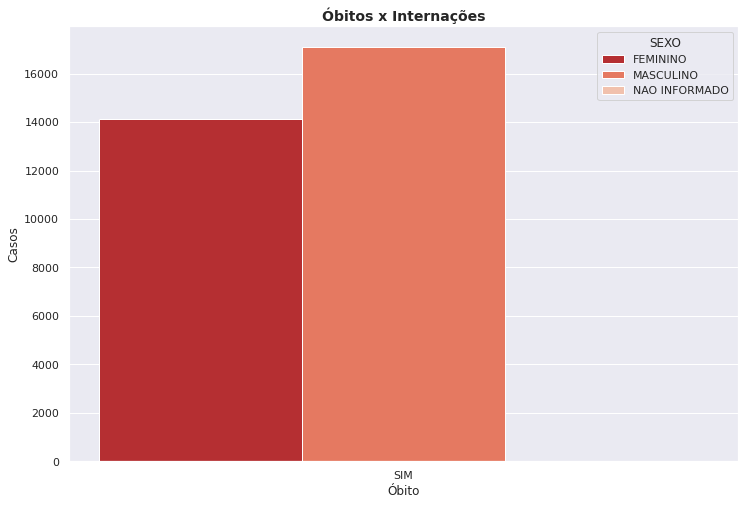

In [41]:
sns_plot(data=death_count, x='INTERNACAO', y='EVOLUCAO', hue='SEXO', kind='bar', palette='Reds_r', title='Óbitos x Internações', xlabel='Óbito', ylabel='Casos', xtickrot=0)

Curiosamente, todas as pessoas que evoluíram para óbito no dataset foram internadas, isso é um fator negativo para uso em modelo de ML posterior pois é tendencioso, ou seja, pode induzir o modelo a classificar internados como pessoas que evoluirão para óbito, removendo a capacidade de generalização.

Se todos que evoluíram para óbito foram internados, será que algo semelhante acontece para os que se recuperaram?

Serão verificados os recuperados comparados às internações.

In [42]:
recovered_count = cases_evolution_mg.query("EVOLUCAO == 'RECUPERADO'").groupby(['INTERNACAO','SEXO']).count()['EVOLUCAO'].reset_index()
recovered_count

,INTERNACAO,SEXO,EVOLUCAO
0,NAO,FEMININO,210903
1,NAO,MASCULINO,186383
2,NAO,NAO INFORMADO,514
3,NAO INFORMADO,FEMININO,3844
4,NAO INFORMADO,MASCULINO,3822
5,SIM,FEMININO,24672
6,SIM,MASCULINO,28473
7,SIM,NAO INFORMADO,37


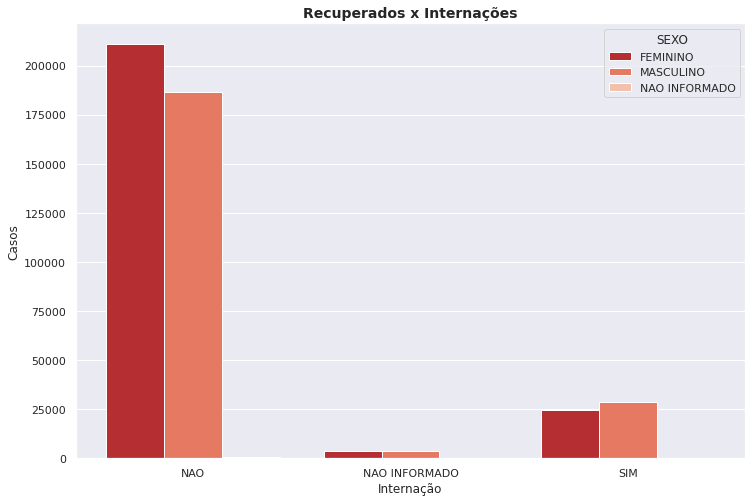

In [43]:
sns_plot(data=recovered_count, x='INTERNACAO', y='EVOLUCAO', hue='SEXO', kind='bar', palette='Reds_r', title='Recuperados x Internações', xlabel='Internação', ylabel='Casos', xtickrot=0)

Neste caso a situação se inverte, a maior parte dos recuperados nao precisou de internação.

Em ambas análises a quantidade de pessoas cujo sexo não foi informado é extremamente pequena, não gerando na plotagem a coluna.

In [44]:
age_range_evolution = cases_evolution_mg.groupby(['FAIXA_ETARIA','EVOLUCAO']).count()['INTERNACAO'].reset_index().sort_values(['FAIXA_ETARIA','EVOLUCAO'], ascending=[True, False]).rename({'INTERNACAO':'CASOS'}, axis=1)
age_range_evolution.head()

,FAIXA_ETARIA,EVOLUCAO,CASOS
1,0 A 11 MESES,RECUPERADO,2970
0,0 A 11 MESES,OBITO,26
3,1 A 9 ANOS,RECUPERADO,10940
2,1 A 9 ANOS,OBITO,21
5,10 A 19 ANOS,RECUPERADO,25485


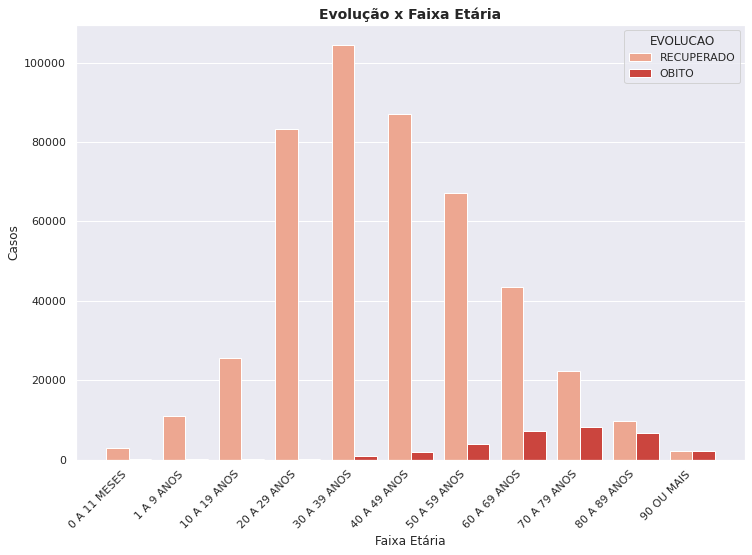

In [45]:
sns_plot(data=age_range_evolution, x='FAIXA_ETARIA', y='CASOS', hue='EVOLUCAO', kind='bar', palette='Reds', title='Evolução x Faixa Etária', xlabel='Faixa Etária', ylabel='Casos')

In [46]:
cases_by_race = cases_evolution_mg.groupby(['RACA']).count()['EVOLUCAO'].reset_index().sort_values(['EVOLUCAO'], ascending=False).rename({'EVOLUCAO':'CASOS'}, axis=1)
cases_by_race.head()

,RACA,CASOS
1,BRANCA,182036
4,PARDA,175280
3,NAO INFORMADO,84796
5,PRETA,24950
0,AMARELA,22379


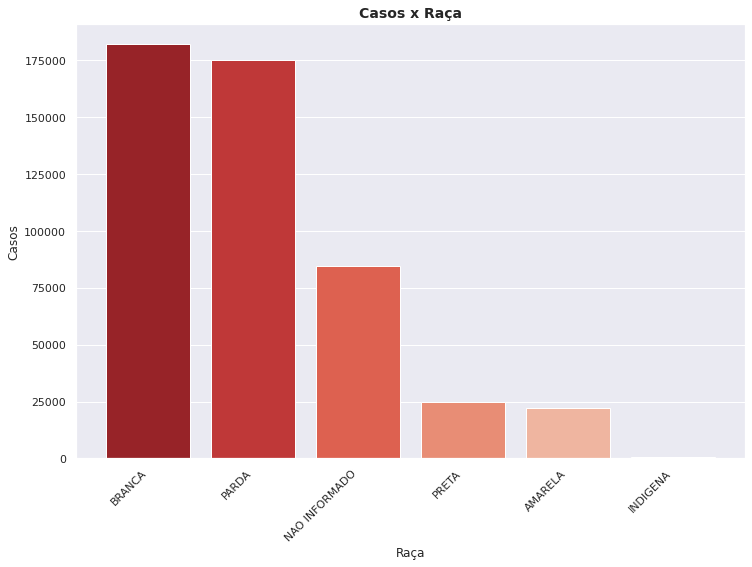

In [47]:
sns_plot(data=cases_by_race, x='RACA', y='CASOS', kind='bar', palette='Reds_r', title='Casos x Raça', xlabel='Raça', ylabel='Casos')

In [48]:
cases_by_macro = cases_evolution_mg.groupby(['MACRO']).count()['EVOLUCAO'].reset_index().sort_values(['EVOLUCAO'], ascending=False).rename({'EVOLUCAO':'CASOS'}, axis=1)
cases_by_macro.head()

,MACRO,CASOS
0,CENTRO,111847
10,SUL,78883
11,TRIANGULO DO NORTE,52067
8,OESTE,42962
13,VALE DO ACO,42774


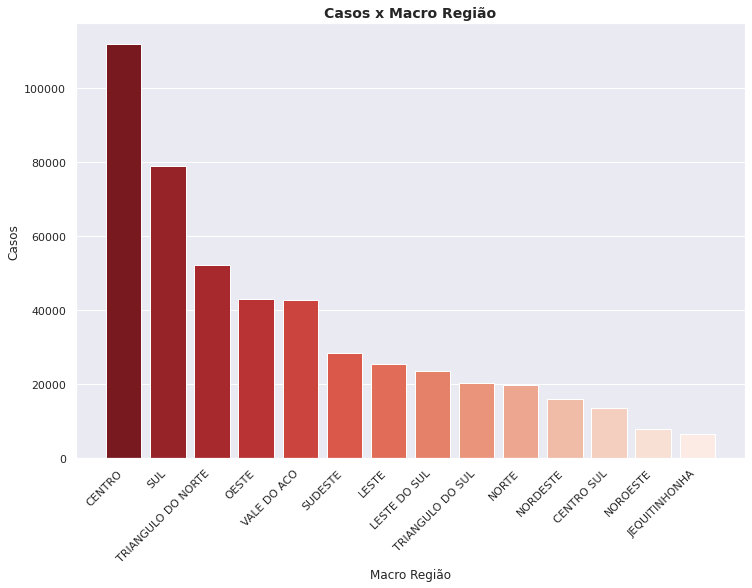

In [49]:
sns_plot(data=cases_by_macro, x='MACRO', y='CASOS', kind='bar', palette='Reds_r', title='Casos x Macro Região', xlabel='Macro Região', ylabel='Casos')

### Correlação

Mapa da correlação de Pearson.

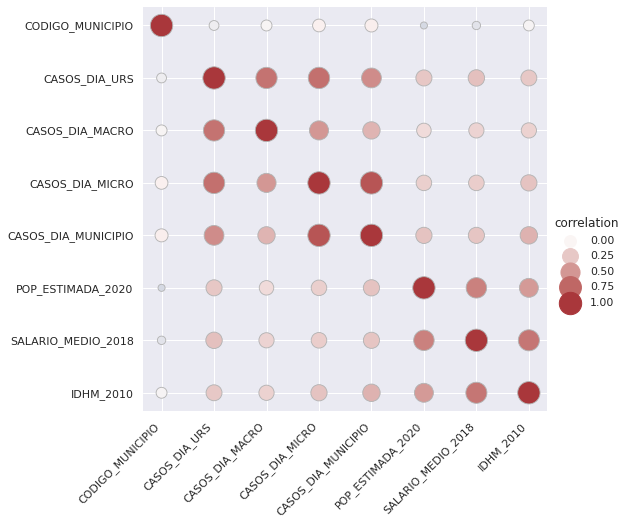

In [50]:
# https://seaborn.pydata.org/examples/heat_scatter.html?highlight=corr
corr_matrix = cases_evolution_mg.corr().stack().reset_index(name="correlation")
g = sns.relplot(
    data=corr_matrix,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=8, sizes=(50, 500), size_norm=(-.2, .8),
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
#g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set(rotation=45,horizontalalignment='right')

## Machine Learning

Nesta seção o objetivo é definir o melhor modelo de ML para prever recuperações e óbitos.

Importação de bibliotecas.

In [51]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer

# Bibliotecas de modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB

### Pré processsamento para ML

Algumas colunas são irrelevantes para os modelos de ML, um exemplo é o aumento da dimensionalidade, ou seja, número de colunas. Portanto algumas remoções serão realizadas.

In [52]:
# Criando um DF para armazenar os códigos de municípios, municípios, URSs, macro e micro regiões para eventual uso futuro
cols_to_drop = ['CODIGO_MUNICIPIO','MUNICIPIO','URS','MACRO','MICRO']
mg_cities = cases_evolution_mg[cols_to_drop].sort_values('CODIGO_MUNICIPIO').drop_duplicates().reset_index(drop=True)
mg_cities.head()

,CODIGO_MUNICIPIO,MUNICIPIO,URS,MACRO,MICRO
0,310010,ABADIA DOS DOURADOS,UBERLANDIA,TRIANGULO DO NORTE,PATROCINIO/MONTE CARMELO
1,310020,ABAETE,SETE LAGOAS,CENTRO,SETE LAGOAS
2,310030,ABRE CAMPO,MANHUACU,LESTE DO SUL,MANHUACU
3,310040,ACAIACA,PONTE NOVA,LESTE DO SUL,PONTE NOVA
4,310050,ACUCENA,CORONEL FABRICIANO,VALE DO ACO,IPATINGA


In [53]:
# Novo dataframe para ML sem algumas colunas
ml_cases_evolution_mg = cases_evolution_mg.drop(columns=cols_to_drop)
ml_cases_evolution_mg.drop(columns=['DATA_NOTIFICACAO'], inplace=True)
ml_cases_evolution_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489888 entries, 0 to 489887
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SEXO                  489888 non-null  string 
 1   FAIXA_ETARIA          489888 non-null  string 
 2   EVOLUCAO              489888 non-null  string 
 3   INTERNACAO            489888 non-null  string 
 4   UTI                   489888 non-null  string 
 5   RACA                  489888 non-null  string 
 6   COMORBIDADE           489888 non-null  string 
 7   ORIGEM_DA_INFORMACAO  489888 non-null  string 
 8   CASOS_DIA_URS         489888 non-null  int64  
 9   CASOS_DIA_MACRO       489888 non-null  int64  
 10  CASOS_DIA_MICRO       489888 non-null  int64  
 11  CASOS_DIA_MUNICIPIO   489888 non-null  int64  
 12  POP_ESTIMADA_2020     489888 non-null  int64  
 13  SALARIO_MEDIO_2018    489888 non-null  float64
 14  IDHM_2010             489888 non-null  float64
dtype

Alguns modelos não trabalham com dados categóricos e precisam ser convertidos.

Label encoder: transforma classes de dados categóricos em números que os representam.

One-hot encoder: cada classe de dado categórico é convertida em uma nova coluna e aplica o valor 0 (zero) ou 1 (um).

O One-hot encoder, quando aplicado corretamente pode melhorar os modelos, porém gera aumento de dimensionalidade (mais colunas).

Dessa forma deve-se avaliar a cardinalidade, ou seja, a quantidade de registros únicos de uma coluna, por exemplo, uma coluna Sexo, que contém apenas M ou F, possui cardinalidade 2. Portanto apenas variáveis categóricas de baixa cardinalidade são candidatas a serem convertidas com o One-hot encoder, as demais usarão o Label encoder.

In [54]:
# Label encoder x One-hot encoder
categ_cols = ml_cases_evolution_mg.select_dtypes(include=['string']).columns

# Colunas para one-hot encoder
low_cardinality_cols = [col for col in categ_cols if ml_cases_evolution_mg[col].nunique() <= 3]
low_cardinality_cols.remove('EVOLUCAO') # Variável resposta será codificada com o label encoder

# Colunas para label encoder
high_cardinality_cols = list(set(categ_cols)-set(low_cardinality_cols))

# Apply one-hot encoder to each column with categorical data
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_df = pd.DataFrame(oh_encoder.fit_transform(ml_cases_evolution_mg[low_cardinality_cols]), columns=oh_encoder.get_feature_names(low_cardinality_cols))
oh_df.index = ml_cases_evolution_mg.index
oh_df.head()

,SEXO_FEMININO,SEXO_MASCULINO,SEXO_NAO INFORMADO,INTERNACAO_NAO,INTERNACAO_NAO INFORMADO,INTERNACAO_SIM,UTI_NAO,UTI_NAO INFORMADO,UTI_SIM,COMORBIDADE_NAO,COMORBIDADE_NAO INFORMADO,COMORBIDADE_SIM
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [55]:
ml_cases_evolution_mg.drop(columns=low_cardinality_cols, inplace=True)
label_encoders = dict()
for col in high_cardinality_cols:
  le = LabelEncoder()
  ml_cases_evolution_mg[col] = le.fit_transform(ml_cases_evolution_mg[col])
  label_encoders[col] = le
ml_cases_evolution_mg = pd.concat([ml_cases_evolution_mg,oh_df],axis=1)
ml_cases_evolution_mg.head()

,FAIXA_ETARIA,EVOLUCAO,RACA,ORIGEM_DA_INFORMACAO,CASOS_DIA_URS,CASOS_DIA_MACRO,CASOS_DIA_MICRO,CASOS_DIA_MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010,SEXO_FEMININO,SEXO_MASCULINO,SEXO_NAO INFORMADO,INTERNACAO_NAO,INTERNACAO_NAO INFORMADO,INTERNACAO_SIM,UTI_NAO,UTI_NAO INFORMADO,UTI_SIM,COMORBIDADE_NAO,COMORBIDADE_NAO INFORMADO,COMORBIDADE_SIM
0,3,1,3,1,375,451,62,33,61288,2.5,0.742,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4,1,4,1,375,451,66,41,444784,3.4,0.749,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,4,1,1,1,375,451,66,41,444784,3.4,0.749,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,6,1,4,1,375,451,66,41,444784,3.4,0.749,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,1,3,1,375,451,66,41,444784,3.4,0.749,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [56]:
label_encoders

{'EVOLUCAO': LabelEncoder(),
 'FAIXA_ETARIA': LabelEncoder(),
 'ORIGEM_DA_INFORMACAO': LabelEncoder(),
 'RACA': LabelEncoder()}

In [57]:
# Teste do label encoder
label_encoders['FAIXA_ETARIA'].inverse_transform(ml_cases_evolution_mg.FAIXA_ETARIA)

array(['20 A 29 ANOS', '30 A 39 ANOS', '30 A 39 ANOS', ...,
       '30 A 39 ANOS', '50 A 59 ANOS', '20 A 29 ANOS'], dtype=object)

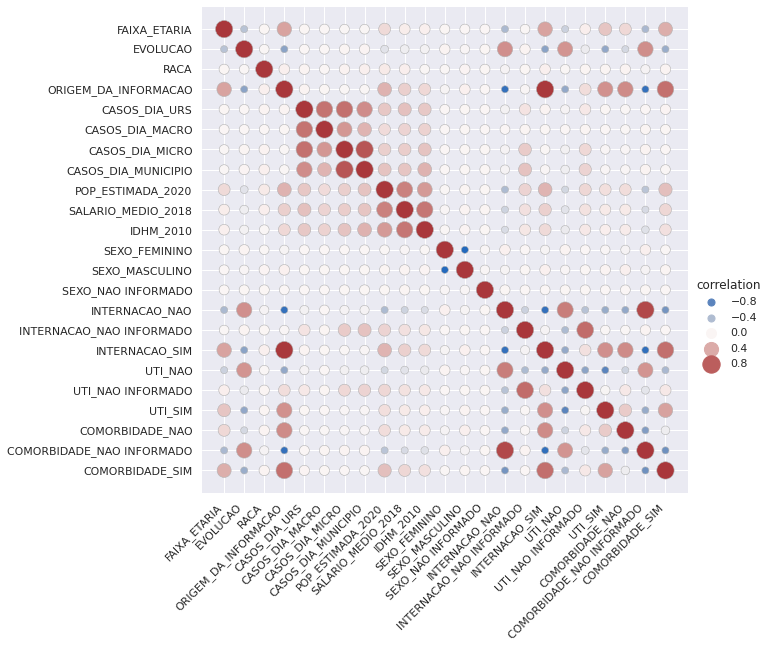

In [58]:
# Apenas visualizando o gráfico atual de correlação
# https://seaborn.pydata.org/examples/heat_scatter.html?highlight=corr
corr_matrix = ml_cases_evolution_mg.corr().stack().reset_index(name="correlation")
g = sns.relplot(
    data=corr_matrix,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 300), size_norm=(-.2, .8),
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
#g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set(rotation=45,horizontalalignment='right')

### Balanceamento

Um dos grandes problemas de classificadores é o de amostras desbalanceadas, ou seja, uma discrepância muito grande nos itens da variável resposta.

Há uma outra situação que, ao deixar em igualdade a quantidade de itens da variável resposta podemos perder capacidade de previsão, portanto é necessário ter esse *tradeoff* em mente.

Como visto na seção de análise dos dados, a quantidade de **recuperados** é muito superior à de **óbitos**. Serão removidos eventuais linhas duplicadas do *dataset* e, posteriormente haverá o balanceamento.

In [59]:
print('Formatos do dataframe\n')
print('Original: ' + str(ml_cases_evolution_mg.shape))
ml_cases_evolution_mg.drop_duplicates(inplace=True)
ml_cases_evolution_mg.reset_index(drop=True, inplace=True)
print('Apóes duplicadas removidas: ' + str(ml_cases_evolution_mg.shape))

Formatos do dataframe

Original: (489888, 23)
Apóes duplicadas removidas: (375133, 23)


In [60]:
# Contagem de óbitos
# Óbito = 0 | Recuperado = 1
ml_total_deaths = ml_cases_evolution_mg.EVOLUCAO[ml_cases_evolution_mg.EVOLUCAO == 0].count()
ml_total_deaths

30249

In [61]:
# Mantendo dataset não balanceado para eventual comparação
nb_ml_cases_evolution_mg = ml_cases_evolution_mg.copy()
# Balanceamento aleatório para óbitos e recuperados possuírem as mesmas quantidades
ml_cases_evolution_mg = pd.concat([ml_cases_evolution_mg.query('EVOLUCAO == 1').sample(ml_total_deaths),ml_cases_evolution_mg.query('EVOLUCAO == 0')], axis=0)
ml_cases_evolution_mg.reset_index(drop=True,inplace=True)
print('Balanceamento aleatório - quantidade de itens')
print(ml_cases_evolution_mg.EVOLUCAO.value_counts())

Balanceamento aleatório - quantidade de itens
1    30249
0    30249
Name: EVOLUCAO, dtype: int64


In [62]:
ml_cases_evolution_mg.head()

,FAIXA_ETARIA,EVOLUCAO,RACA,ORIGEM_DA_INFORMACAO,CASOS_DIA_URS,CASOS_DIA_MACRO,CASOS_DIA_MICRO,CASOS_DIA_MUNICIPIO,POP_ESTIMADA_2020,SALARIO_MEDIO_2018,IDHM_2010,SEXO_FEMININO,SEXO_MASCULINO,SEXO_NAO INFORMADO,INTERNACAO_NAO,INTERNACAO_NAO INFORMADO,INTERNACAO_SIM,UTI_NAO,UTI_NAO INFORMADO,UTI_SIM,COMORBIDADE_NAO,COMORBIDADE_NAO INFORMADO,COMORBIDADE_SIM
0,5,1,1,1,55,469,35,22,120904,2.2,0.756,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4,1,1,1,77,124,50,8,21801,1.9,0.689,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3,1,4,1,61,238,57,23,80494,2.6,0.761,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2,1,4,1,39,63,26,4,8301,1.7,0.660,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,3,1,4,1,172,274,106,1,10118,1.7,0.686,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Separação do treino e teste

In [63]:
# Criando váriáveis X e y
X = ml_cases_evolution_mg.drop('EVOLUCAO', 1)
y = ml_cases_evolution_mg['EVOLUCAO']

# Dataframe não balanceado
nb_X = nb_ml_cases_evolution_mg.drop('EVOLUCAO', 1)
nb_y = nb_ml_cases_evolution_mg['EVOLUCAO']

# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Treino e teste não balanceado
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(nb_X, nb_y, test_size = 0.3)

In [64]:
print("Treino - X: " + str(X_train.shape) + " | y: " + str(y_train.shape))
print("Teste - X: " + str(X_test.shape) + " | y: " + str(y_test.shape))

Treino - X: (42348, 22) | y: (42348,)
Teste - X: (18150, 22) | y: (18150,)


### Modelos

In [65]:
# Automatiza a execução dos modelos e obtenção dos resultados
def run_classifier(classifier, Xtrain, Xtest, ytrain, ytest, target_labels = None):
  results = list()

  params_tree = {
      'criterion': ['gini','entropy'],
      'max_depth': [5, 15]
  }
  params_svc = {
      'kernel': ['poly', 'rbf', 'sigmoid']
  }
  params_xgb = {
      'n_estimators': [100, 150]
  }
  params_gbc = {
      'n_estimators': [100, 150]
  }
  params_knc = {
      'n_neighbors': [3, 5]
  }

  if type(classifier) != list:
    classifier = [classifier]

  for clf in classifier:
    model_name = clf.__class__.__name__

    if (model_name == 'DecisionTreeClassifier') | (model_name == 'RandomForestClassifier'):
      params = params_tree
    elif model_name == 'GaussianNB':
      params = {}
    elif model_name == 'SVC':
      params = params_svc
    elif model_name == 'XGBClassifier':
      params = params_xgb
    elif model_name == 'GradientBoostingClassifier':
      params = params_gbc
    elif model_name == 'KNeighborsClassifier':
      params = params_knc
    else:
      raise Exception('Model not yet supported. Supported models: GaussianNB, DecisionTreeClassifier, RandomForestClassifier, SVC, XGBClassifier, GradientBoostingClassifier, KNeighborsClassifier.')
    
    grid_search = GridSearchCV(estimator=clf,param_grid=params)
    grid_search.fit(Xtrain, ytrain)
    predictions = grid_search.predict(Xtest)
    accuracy = accuracy_score(ytest,predictions)
    print(f'----------- MODELO: {model_name} -----------\n')
    print(f'Melhores parâmetros: {grid_search.best_params_}\n')
    print('Matriz de confusão:\n',pd.DataFrame(data=confusion_matrix(ytest, predictions), index=target_labels, columns=target_labels))
    print(f'\nAcurácia:\n{(accuracy*100):.2f}% ({accuracy})')
    print('\nRelatório de classificação:\n',classification_report(ytest, predictions, target_names=target_labels))
    print(f'------------------------------------------------------\n\n\n')
    result = dict()
    result['model'] = model_name
    result['best_params'] = grid_search.best_params_
    result['params'] = grid_search.best_estimator_.get_params()
    result['accuracy'] = accuracy
    result['report'] = classification_report(ytest, predictions, target_names=target_labels, output_dict=True)
    results.append(result)

  return results

In [66]:
# Modelos a serem usados
model_gsn = GaussianNB()
model_dtc = DecisionTreeClassifier()
model_rfc = RandomForestClassifier()
model_svm = SVC()
model_xgb = XGBClassifier()
model_gbc = GradientBoostingClassifier()
model_knc = KNeighborsClassifier()

#### Execução

Comparação entre a amostra balanceada e não balanceda usando árvore de decisão com configurações padrão.

In [67]:
def decision_tree(X,y,Xt,yt):
  dt_model = DecisionTreeClassifier()
  dt_model.fit(X, y)
  dt_predictions = dt_model.predict(Xt)
  accuracy = accuracy_score(yt,dt_predictions)
  print('Matriz de confusão:\n',pd.DataFrame(data=confusion_matrix(yt, dt_predictions), index=['OBITO','RECUPERADO'], columns=['OBITO','RECUPERADO']))
  print(f'\nAcurácia:\n{(accuracy*100):.2f}% ({accuracy})')
  print('\nRelatório de classificação:\n',classification_report(yt, dt_predictions, target_names=['OBITO','RECUPERADO']))
  #print(plot_tree(dt_model))

In [68]:
print("##### Não Balanceado #####")
decision_tree(nb_X_train,nb_y_train,nb_X_test,nb_y_test)
print("\n\n##### Balanceado #####")
decision_tree(X_train,y_train,X_test,y_test)

##### Não Balanceado #####
Matriz de confusão:
             OBITO  RECUPERADO
OBITO        5044        4044
RECUPERADO   4311       99141

Acurácia:
92.58% (0.9257597298738226)

Relatório de classificação:
               precision    recall  f1-score   support

       OBITO       0.54      0.56      0.55      9088
  RECUPERADO       0.96      0.96      0.96    103452

    accuracy                           0.93    112540
   macro avg       0.75      0.76      0.75    112540
weighted avg       0.93      0.93      0.93    112540



##### Balanceado #####
Matriz de confusão:
             OBITO  RECUPERADO
OBITO        8176        1021
RECUPERADO    905        8048

Acurácia:
89.39% (0.8938842975206611)

Relatório de classificação:
               precision    recall  f1-score   support

       OBITO       0.90      0.89      0.89      9197
  RECUPERADO       0.89      0.90      0.89      8953

    accuracy                           0.89     18150
   macro avg       0.89      0.89      0.89

Se for avaliado apenas a acurácia, o modelo com a amostra não balanceada poderia ser considerado o melhor, porém acurária não é tudo.

Nota-se, especialmente pela precisão e f1-score, que o desempenho da amostra balanceada é melhor que da não balanceada, ou seja, houveram mais acertos em ambas classes.

Agora ocorrerá a xecução de diversos classificadores com a amostra balanceada.

In [69]:
models_results = run_classifier([model_gsn,model_dtc,model_rfc,model_xgb,model_gbc,model_knc],X_train,X_test,y_train,y_test,target_labels=['OBITO','RECUPERADO'])

----------- MODELO: GaussianNB -----------

Melhores parâmetros: {}

Matriz de confusão:
             OBITO  RECUPERADO
OBITO        2275        6922
RECUPERADO   1133        7820

Acurácia:
55.62% (0.556198347107438)

Relatório de classificação:
               precision    recall  f1-score   support

       OBITO       0.67      0.25      0.36      9197
  RECUPERADO       0.53      0.87      0.66      8953

    accuracy                           0.56     18150
   macro avg       0.60      0.56      0.51     18150
weighted avg       0.60      0.56      0.51     18150

------------------------------------------------------



----------- MODELO: DecisionTreeClassifier -----------

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 5}

Matriz de confusão:
             OBITO  RECUPERADO
OBITO        9058         139
RECUPERADO   1063        7890

Acurácia:
93.38% (0.9337741046831955)

Relatório de classificação:
               precision    recall  f1-score   support

       OBITO    

#### Verificação dos resultados

In [70]:
models_results

[{'accuracy': 0.556198347107438,
  'best_params': {},
  'model': 'GaussianNB',
  'params': {'priors': None, 'var_smoothing': 1e-09},
  'report': {'OBITO': {'f1-score': 0.3609678698928997,
    'precision': 0.6675469483568075,
    'recall': 0.24736327063172775,
    'support': 9197},
   'RECUPERADO': {'f1-score': 0.6600548638953365,
    'precision': 0.5304571971238637,
    'recall': 0.8734502401429688,
    'support': 8953},
   'accuracy': 0.556198347107438,
   'macro avg': {'f1-score': 0.5105113668941181,
    'precision': 0.5990020727403356,
    'recall': 0.5604067553873483,
    'support': 18150},
   'weighted avg': {'f1-score': 0.5085009749785094,
    'precision': 0.5999235575695598,
    'recall': 0.556198347107438,
    'support': 18150}}},
 {'accuracy': 0.9337741046831955,
  'best_params': {'criterion': 'gini', 'max_depth': 5},
  'model': 'DecisionTreeClassifier',
  'params': {'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 5,
   'max_features': None,


In [71]:
print('##### Acurácias #####')
for model_result in models_results:
  print(f"{model_result['model']}: {(model_result['accuracy']*100):.2f}%")

##### Acurácias #####
GaussianNB: 55.62%
DecisionTreeClassifier: 93.38%
RandomForestClassifier: 93.44%
XGBClassifier: 93.60%
GradientBoostingClassifier: 93.63%
KNeighborsClassifier: 70.58%


## Apresentação dos resultados

Convertendo resultados para *Dataframe*.

In [72]:
rows = list()
for model_result in models_results:
  item = list()
  item.append(model_result['model'])
  item.append(model_result['accuracy'])
  item.append(model_result['report']['OBITO']['f1-score'])
  item.append(model_result['report']['OBITO']['precision'])
  item.append(model_result['report']['OBITO']['recall'])
  item.append(model_result['report']['OBITO']['support'])
  item.append(model_result['report']['RECUPERADO']['f1-score'])
  item.append(model_result['report']['RECUPERADO']['precision'])
  item.append(model_result['report']['RECUPERADO']['recall'])
  item.append(model_result['report']['RECUPERADO']['support'])
  rows.append(item)

df_models_results = pd.DataFrame(rows, columns=['modelo','acurácia','f1-score óbito','precisão óbito','revocação óbito','suporte óbito',
                                                'f1-score recuperado','precisão recuperado','revocação recuperado','suporte recuperado'])
df_models_results

,modelo,acurácia,f1-score óbito,precisão óbito,revocação óbito,suporte óbito,f1-score recuperado,precisão recuperado,revocação recuperado,suporte recuperado
0,GaussianNB,0.556198,0.360968,0.667547,0.247363,9197,0.660055,0.530457,0.873450,8953
1,DecisionTreeClassifier,0.933774,0.937778,0.894971,0.984886,9197,0.929219,0.982688,0.881269,8953
2,RandomForestClassifier,0.934435,0.938495,0.894395,0.987170,9197,0.929802,0.985248,0.880264,8953
3,XGBClassifier,0.935978,0.939874,0.896633,0.987496,9197,0.931542,0.985663,0.883056,8953
4,GradientBoostingClassifier,0.936309,0.940066,0.898424,0.985756,9197,0.932048,0.983745,0.885513,8953
5,KNeighborsClassifier,0.705840,0.707340,0.713243,0.701533,9197,0.704325,0.698484,0.710265,8953


### Gráficos

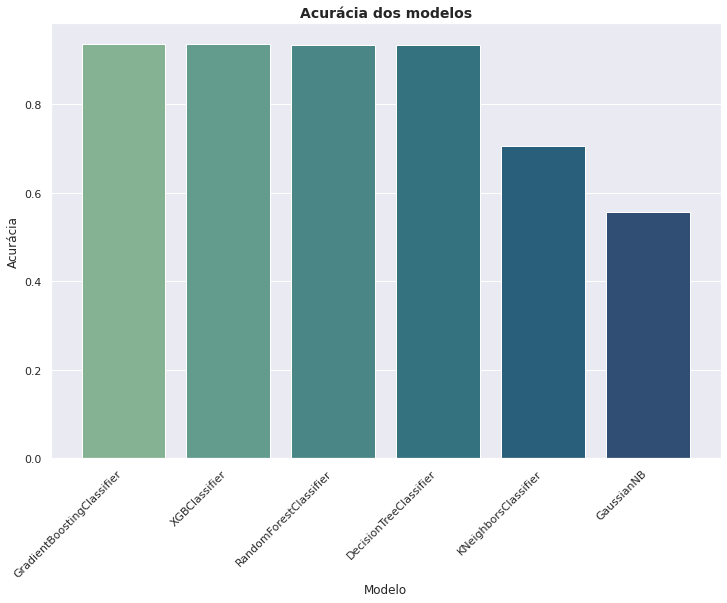

In [73]:
sns_plot(x='modelo', y='acurácia', palette='crest', data=df_models_results.sort_values('acurácia', ascending=False), title='Acurácia dos modelos', xlabel='Modelo', ylabel='Acurácia', kind='bar')

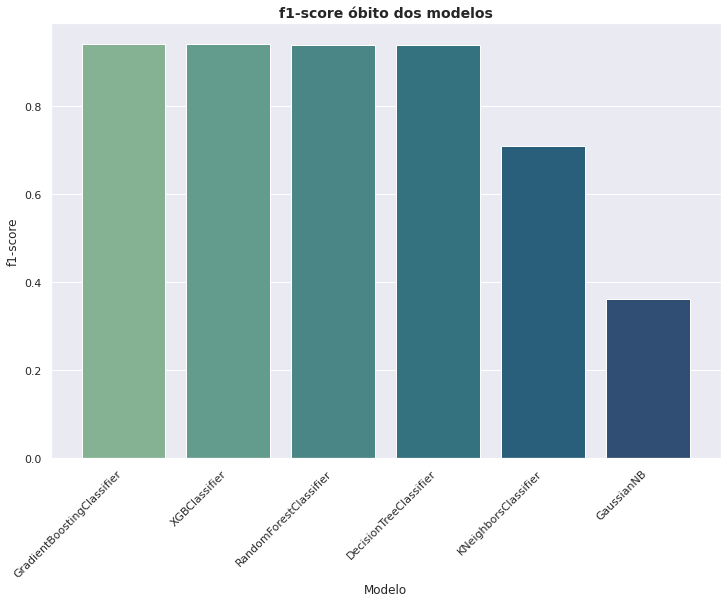

In [74]:
sns_plot(x='modelo', y='f1-score óbito', palette='crest', data=df_models_results.sort_values('f1-score óbito', ascending=False), title='f1-score óbito dos modelos', xlabel='Modelo', ylabel='f1-score', kind='bar')

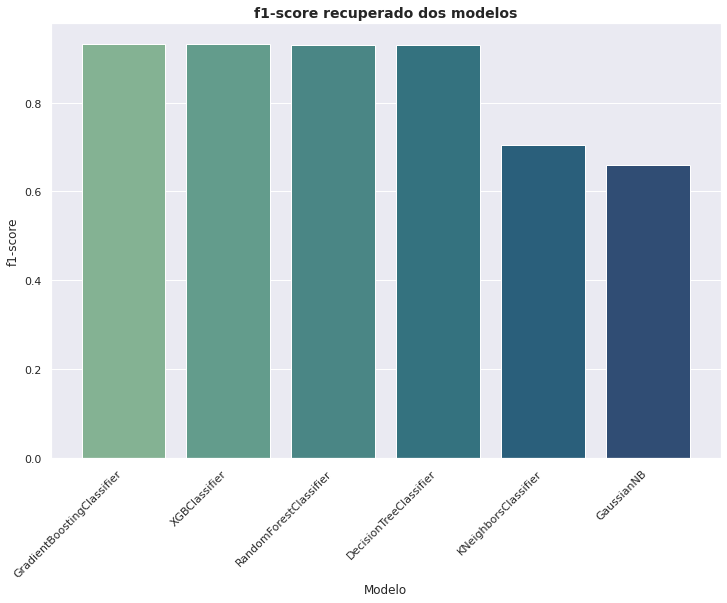

In [75]:
sns_plot(x='modelo', y='f1-score recuperado', palette='crest', data=df_models_results.sort_values('f1-score recuperado', ascending=False), title='f1-score recuperado dos modelos', xlabel='Modelo', ylabel='f1-score', kind='bar')

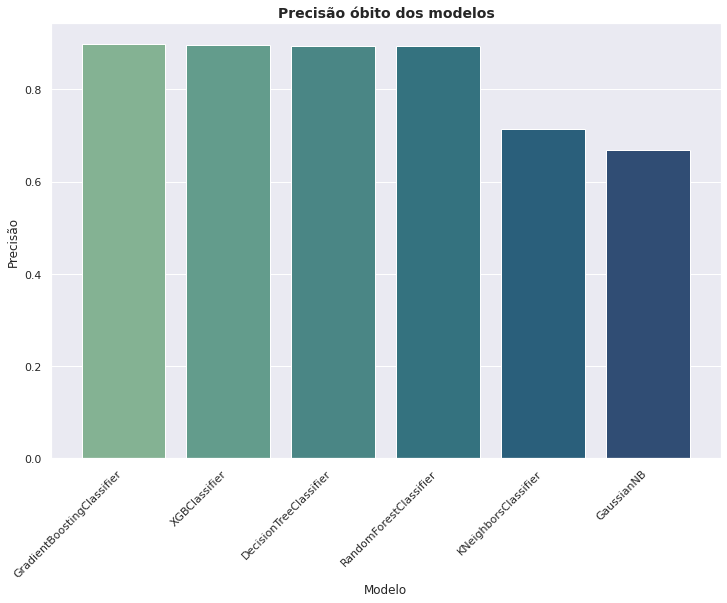

In [76]:
sns_plot(x='modelo', y='precisão óbito', palette='crest', data=df_models_results.sort_values('precisão óbito', ascending=False), title='Precisão óbito dos modelos', xlabel='Modelo', ylabel='Precisão', kind='bar')

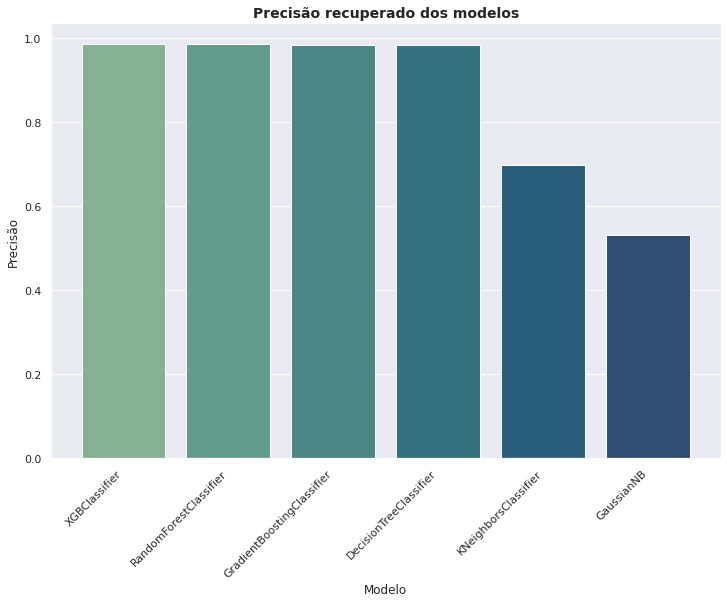

In [77]:
sns_plot(x='modelo', y='precisão recuperado', palette='crest', data=df_models_results.sort_values('precisão recuperado', ascending=False), title='Precisão recuperado dos modelos', xlabel='Modelo', ylabel='Precisão', kind='bar')

Temos um vencedor!

O modelo que apresentou melhor desempenho, baseado na avaliação dos resultados, em especial f1-score foi o **GradientBostClassifier**, seguido de perto pelo **XGBClassifier** e em terceiro lugar o **RandomForestClassifier**.

Ranking:

1.   GradientBostClassifier
2.   XGBClassifier
3.   RandomForestClassifier



In [78]:
df_models_results.sort_values(['f1-score óbito','f1-score recuperado'], ascending=[False,False]).reset_index(drop=True)

,modelo,acurácia,f1-score óbito,precisão óbito,revocação óbito,suporte óbito,f1-score recuperado,precisão recuperado,revocação recuperado,suporte recuperado
0,GradientBoostingClassifier,0.936309,0.940066,0.898424,0.985756,9197,0.932048,0.983745,0.885513,8953
1,XGBClassifier,0.935978,0.939874,0.896633,0.987496,9197,0.931542,0.985663,0.883056,8953
2,RandomForestClassifier,0.934435,0.938495,0.894395,0.987170,9197,0.929802,0.985248,0.880264,8953
3,DecisionTreeClassifier,0.933774,0.937778,0.894971,0.984886,9197,0.929219,0.982688,0.881269,8953
4,KNeighborsClassifier,0.705840,0.707340,0.713243,0.701533,9197,0.704325,0.698484,0.710265,8953
5,GaussianNB,0.556198,0.360968,0.667547,0.247363,9197,0.660055,0.530457,0.873450,8953
